# The Elements of Statistical Learning

## Ejercicio completo de machine learning 1: 

Clasificación de puntos en un plano según dos posibles categorias, puntos rojos o azules

Este notebook incluye todos los pasos tipicos de un ejercicio de Machine Learning, enfocandose en un problema de clasificacion entre dos categorias (rojo o azul) de los puntos de un plano. Todo esto en busqueda del grafico 2.4 del libro The Elements. Este notebook se dividirá en las siguientes partes:

- Simulación de datos del train y del test
    - En muchos ejercicios de Machine Learning estos datos son dados como condicion inicial, pero en nuestro caso nosotros los simulamos. Debemos recordar que una de las suposiciones de ML es que los datos siguen cierta funcion de probabilidad y que en principio conociendo esta funcion podriamos simularlos
- Definicion de la función para calcular las predicciones o hacer la clasificacion (lineal,sigmoide, Knn, etc)
    - En el lenguaje de ML esta funcion es llamada Hipótesis
- Definicion de la función costo 
    -  En un primer caso usamos RSS como funcion de costo, pero en general podriamos considerar otras funciones de costo, dependiendo de las propiedades particulares de cada problema
- Minimización de la función costo para encontrar los parámetros libres de la hipótesis 
    - En un primer caso encontramos los valores de los parametros theta de la funcion lineal minimizando analiticamente la funcion costo RSS, en lenguaje de ML esta ecuación es denominada Normal Equation. 
    - Sin embargo es necesario notar que también existen otros metodos, que son numericos en general. Por ejemplo, anteriormente usamos la busqueda aleatoria de los paramteros seleccionando sistematicamente los valores que reducen RSS. Otro metodo, con nombre de hecho, es Gradient Descent que es el mas tipico de Machine Learning.
- Visualizacion de las predicciones en el train y el test
- Evaluacion cuantitativa de las predicciones en terminos de la accuracy y el test error
    - Estos resultados nos permitiran escoger los mejores modelos para el problema planteado
- Gráfico de la misclassification curves (Figure 2.4)

Inicialmente importamos la librería que utilizaremos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Simulación de datos:

Dado las indicaciones en la pagina 16 del libro "The Elements of Statistical Learning", se puede entender que el proceso de simulación del set de datos de entrenamiento es el siguiente.

1- Primero se escoge el color a simular

2- Dado el color, conocemos el centro y la matriz de covarianza de una gaussiana bivariada

3- Con esta gaussiana bivariada generamos 10 centros. Esto lo hacemos solo una vez porque nos permite generar las observaciones asociadas a un set fijo de gaussianas bivariadas, 10 en nuestro caso. La idea de la simulación es generar observaciones que representen instancias asociados a un set de gaussianas bivariadas, no con respecto a una sola de ellas

4- Con estos valores de los centros, mas una covarianza fija igual a la identidad/5, podemos asumir que conocemos los parametros de 10 gaussianas bivariadas

5- Considerando estas 10 gaussianas bivariadas podemos generar nuestras observaciones

6- Cada observacion se genera de la siguiente forma:

    1- Se escoge uno de los centros dados anteriormente y su gaussiana bivariada correspondiente
    2- Se genera un valor de la posicion siguiendo esta gaussiana bivariada   
    3- Se vuelve a 6.1 y se repite el proceso, 100 veces por cada color

### Definicion de los centros de las gaussianas bivariadas

In [2]:
def centros_asociados_a_cada_color(color, kcentros):
   
    centro = np.array([0,0])
    covarianza = np.identity(2)
    
    if color == 0: #azul
        centro = np.array([1,0])
    
    if color == 1: #rojo
        centro = np.array([0,1])

    lista_de_centros = np.random.multivariate_normal(centro,covarianza,kcentros).T
        
    return lista_de_centros

In [3]:
centros_azul = centros_asociados_a_cada_color(0,10)
centros_rojo = centros_asociados_a_cada_color(1,10)

In [4]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-4,4,-4,4])
    plt.title("Distribucion de puntos segun el color")
    plt.show() 

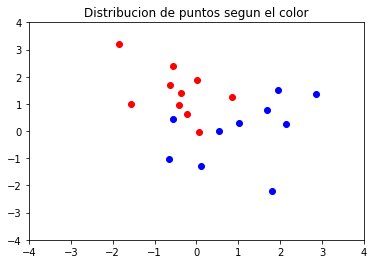

In [5]:
visualize_colors(centros_azul, centros_rojo)

### Implementacion de la funcion que simula los datos

In [6]:
def Simulacion(centros, N):
    
    Ncentros = centros.shape[1]
    
    #Inicializamos la lista de observaciones 
    observations = np.zeros((2,N))
    
    #Definimos un valor global para la covarianza
    covarianza = np.identity(2)/5
       
    #hacemos un loop entre 0 y N para generar todos las observaciones requeridas
    
    for obs in range(0,N):
        #generamos un numero aleatorio entre los números 0 y Ncentros-1 para escoger el centro de nuestra gaussiana bivariada
        indice_del_centro = random.randint(0, Ncentros-1)
        
        xcentro = centros[0,indice_del_centro]
        ycentro = centros[1,indice_del_centro]
        
        mk_centro = np.array([xcentro, ycentro])
        
        centro_aux = np.random.multivariate_normal(mk_centro,covarianza,1).T
    
        observations[0,obs] = centro_aux[0,0]
        observations[1,obs] = centro_aux[1,0]
    
    return observations

### Datos del conjunto de entrenamiento

In [7]:
ptos_observados_azul_train =  Simulacion(centros_azul, 100)
ptos_observados_rojo_train =  Simulacion(centros_rojo, 100)

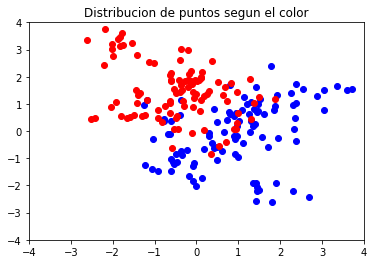

In [8]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

### Datos del  conjunto de testeo
Se generarán 5000 puntos para cada color (en total serán 10000 puntos) a partir de los mismos 20 centros usados para el conjunto de entrenamiento. 

In [9]:
ptos_observados_azul_test =  Simulacion(centros_azul, 5000)
ptos_observados_rojo_test =  Simulacion(centros_rojo, 5000)

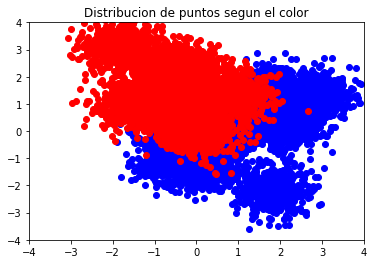

In [10]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

Se generará un segundo conjunto de entrenamiento con 500 puntos para cada color (siendo en total 1000 puntos) a partir de los 20 centros usados para el conjunto de entrenamiento. Esto se realiza debido a las limitaciones de la computadora (en la que se forjó originalmente el código) para analizar el gran número de datos que se formarán más adelante en knn.  

In [11]:
ptos_observados_azul_test_2 =  Simulacion(centros_azul, 500) 
ptos_observados_rojo_test_2 =  Simulacion(centros_rojo, 500)

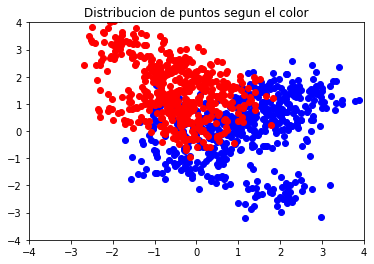

In [12]:
visualize_colors(ptos_observados_azul_test_2, ptos_observados_rojo_test_2)

### Formación del Conjunto de Entrenamiento (SET_train) y del Conjunto de Testeo (SET_test) 

In [13]:
SET_train=[]

x1azul_train = ptos_observados_azul_train[0,:]
x2azul_train = ptos_observados_azul_train[1,:]

x1rojo_train = ptos_observados_rojo_train[0,:]
x2rojo_train = ptos_observados_rojo_train[1,:]

# Se agregan estos puntos a SET_train con su correspondiente valor de Y. Si Y=0 corresponde a 
# la distribución normal azul. Si Y=1 corresponde a la distribución normal roja. Adicionalmente se agregará
# el bias al inicio de cada fila en SET_train.

for i in range(len(x1azul_train)): #Y=0
    SET_train.append([1,x1azul_train[i],x2azul_train[i],0])

for i in range(len(x1rojo_train)): #Y=1
    SET_train.append([1,x1rojo_train[i],x2rojo_train[i],1])

In [14]:
SET_test=[]

x1azul_test = ptos_observados_azul_test[0,:]
x2azul_test = ptos_observados_azul_test[1,:]

x1rojo_test = ptos_observados_rojo_test[0,:]
x2rojo_test = ptos_observados_rojo_test[1,:]

for i in range(len(x1azul_test)): #Y=0
    SET_test.append([1,x1azul_test[i],x2azul_test[i],0])

for i in range(len(x1rojo_test)): #Y=1
    SET_test.append([1,x1rojo_test[i],x2rojo_test[i],1])

Adicionalmente se creará SET_test_2 que corresponde al segundo conjunto de testeo formado para solventar las limitaciones de la computadora en donde se forjó originalemte el código. Si su computadora es capaz de llevar a cabo este tipo de tareas con rapidez utilice SET_test en vez de SET_test_2.

In [15]:
SET_test_2=[]

x1azul_test_2 = ptos_observados_azul_test_2[0,:]
x2azul_test_2 = ptos_observados_azul_test_2[1,:]

x1rojo_test_2 = ptos_observados_rojo_test_2[0,:]
x2rojo_test_2 = ptos_observados_rojo_test_2[1,:]

for i in range(len(x1azul_test_2)): #Y=0
    SET_test_2.append([1,x1azul_test_2[i],x2azul_test_2[i],0])

for i in range(len(x1rojo_test_2)): # Y=1
    SET_test_2.append([1,x1rojo_test_2[i],x2rojo_test_2[i],1])

Los largos correspondientes a cada SET se muestran a continuación.

In [16]:
print(len(SET_train), len(SET_test),len(SET_test_2))

200 10000 1000


## Análisis de funciones para calcular predicciones.

## Caso 1: Mínimos cuadrados

- Hipótesis: función lineal
- Función costo: RSS 
- Minimización: theta obtenido teóricamente (Normal Equation)
- Evaluación: accuracy y test error

En este caso asumimos que el modelo de clasificación o hipotesis esta dado por una funcion lineal del tipo 

$$ h(x_1^{(i)},x_2^{(i)}) = \theta_0 + \theta_1 x_1^{(i)} + \theta_2 x_2^{(i)} $$

y que los valores de theta son obtenidos a partir de la busqueda del minimo de la funcion RSS con respecto a los datos del conjunto de entrenamiento. Este minimo puede ser encontrado analitcamente, como es nuestro caso actual, pero tambien puede ser encontrado numericamente, por ejemplo utilizando generacion de puntos aleatorios y seleccion del minimo. 

Forma analítica:

$$ RSS(\theta) =  \sum_{i=1}^m (y^{(i)}
- x^{(i)}\theta)^2$$
m indica el número de puntos, los que son de la forma $(x^{(1)},y^{(1)}),(x^{(2)},y^{(2)})...,(x^{(m)},y^{(m)})$.
Utilizando notación matricial, RSS() queda como:

$$ RSS(\theta) = (Y - X\theta)^T(Y - X\theta)$$

Cabe destacar que en este ejercicio en particular, $\theta$ posee una dimensión igual a 3, Y tiene una dimensión igual a $N$ y X una dimensión de $N x 3$.

Finalmente, para encontrar los coeficientes que componen a vector $\theta$ se debe derivar RSS() con respecto a $\theta$ y luego igualar a 0, con lo que se obtiene lo siguiente.
$$\hat{\theta} = (X^T X)^{-1}X^T Y$$

Otra forma de hacer esta busqueda del minimo de RSS o funcion de costo en el lenguage de Machine Learning es utilizando una tecnica llamada Gradient Descent que es tipica en ML y que aparece explicado en el segundo item del curso Machine Learning de Andrew Ng.

In [19]:
X=[]
Y=[]

#Los valores de SET[i][1] y SET[i][2] se colocarán en X y se vizualizarán como las nuevas variables x1 y x2.
for i in range(len(SET_train)):  
    X.append([1,SET_train[i][1],SET_train[i][2]])


#Ahora se colocarán los valores SET[i][3] en Y.
for i in range(len(SET_train)): 
    Y.append(SET_train[i][3])
    
X=np.array(X)                     
Y=np.array(Y)

XT=X.transpose()

In [20]:
print(X.shape, Y.shape, XT.shape)

(200, 3) (200,) (3, 200)


In [21]:
XTdotX = np.dot(XT,X)
XTdotX

array([[200.        ,  43.53157432, 135.92797939],
       [ 43.53157432, 344.17815124, -69.81431324],
       [135.92797939, -69.81431324, 453.66809289]])

In [22]:
XTdotX_inversa = np.linalg.inv(XTdotX)
XTdotX_inversa

array([[ 0.00681125, -0.00131654, -0.00224339],
       [-0.00131654,  0.00325356,  0.00089515],
       [-0.00224339,  0.00089515,  0.00301417]])

In [23]:
XTdotX_inversa_dotXT = np.dot(XTdotX_inversa, XT)

In [24]:
theta_analitico = np.dot(XTdotX_inversa_dotXT,Y)
print(theta_analitico)

[ 0.4187827  -0.16048495  0.17089655]


### Visualizacion de las predicciones considerando los datos del conjunto de testeo y del conjunto de entrenamiento

Con el valor del vector theta_analitico es posible visualizar como funciona este modelo de prediccion con la función lineal para los puntos del conjunto de entrenamuiento y del conjunto de testeo separadamente.

Para esto, primero se necesita crear las siguientes funciones:

In [25]:
def funcion_lineal(x1, x2, theta): 
    
    y_prediccion = theta[0] + x1*theta[1] + x2*theta[2]
    return y_prediccion 

In [26]:
def listas_de_predicciones_lineal(SET):

    lista_de_predicciones_azul = []
    lista_de_predicciones_rojo = []

    for pto in range(len(SET)):
        prediccion = funcion_lineal(SET[pto][1], SET[pto][2], theta_analitico)

    #Utilizando el valor de la prediccion separamos entre puntos azules y rojos
    
        if (prediccion <= 0.5):
            lista_de_predicciones_azul.append([SET[pto][1], SET[pto][2]])
        if (prediccion > 0.5):
            lista_de_predicciones_rojo.append([SET[pto][1], SET[pto][2]])
        
    return np.array(lista_de_predicciones_azul), np.array(lista_de_predicciones_rojo)

Para visualizar las predicciones hechas haremos lo siguiente.

In [27]:
prediccion_azul_train_lineal, prediccion_rojo_train_lineal = listas_de_predicciones_lineal(SET_train)

prediccion_azul_train_lineal_t = prediccion_azul_train_lineal.transpose()
prediccion_rojo_train_lineal_t = prediccion_rojo_train_lineal.transpose()

In [28]:
prediccion_azul_test_lineal, prediccion_rojo_test_lineal = listas_de_predicciones_lineal(SET_test)

prediccion_azul_test_lineal_t = prediccion_azul_test_lineal.transpose()
prediccion_rojo_test_lineal_t = prediccion_rojo_test_lineal.transpose()

Con esto podemos comparar visualmente las predicciones sobre el conjunto de entrenamiento y el coonjunto de testeo. A continuación se observan los 200 puntos simulados inicialmente que pertenecen al conjunto de entrenamiento.

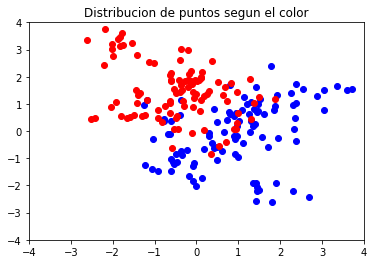

In [29]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

A continuación se observa la predicción hecha por la función lineal en el conjunto de entrenamiento:

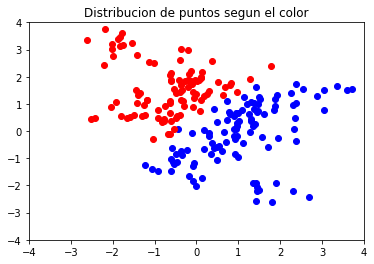

In [30]:
visualize_colors(prediccion_azul_train_lineal_t, prediccion_rojo_train_lineal_t)

A continuación observamos los 10000 puntos creados anteriormente que pertenecen al SET_test:

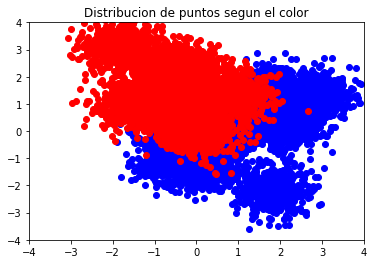

In [31]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

A continuación se observa la predicción hecha por la función lineal para estos puntos pertenecientes a SET_test:

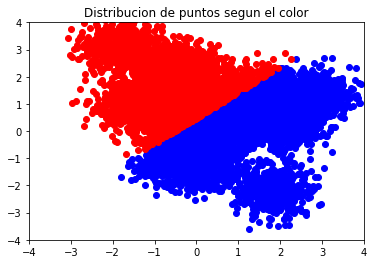

In [32]:
visualize_colors(prediccion_azul_test_lineal_t, prediccion_rojo_test_lineal_t)

### Evaluación de la hipotesis lineal en terminos de las metricas "Accuracy" y el "Test Error"

Por definicion vamos a considerar que la accuracy y el test error estan dados por

$$Accuracy = \frac{PC}{PC+ PI}$$ 
Con PC los puntos predichos correctamente y PI los puntos predichos incorrectamente

$$Test_{error} = 1 - accuracy$$

Estas son métricas que nos permiten evaluar la performance de la hipótesis (en este caso la función lineal) una vez que hemos encontrado los valores de los parametros libres ($\theta$). Evaluaremos estas dos métricas en ambos conjuntos de datos (el de entrenamiento y el de testeo).

El valor del Accuracy (o la exactitud) medido en el conjunto de entrenamiento nos indica cuantitativamente el nivel de aprendizaje del modelo, dado que en este paso estamos intentando ajustar el modelo a los datos conocidos. Mientras que el Acurracy medido en el conjunto de testeo nos indica su poder de prediccion, dado que estos datos no fueron utilizados para el entrenamiento del modelo. 

Normalmente se espera que el valor de la Accuracy sea mejor (o más cercano a 1) en el conjunto de entrenamiento que en el conjunto de testeo, porque los datos del primer conjunto fueron los utilizados para calcular los parametros del modelo. Sin embargo esto no está garantizado matemáticamente.

En general es recomendable obtener un valor del accuracy cercano a 1 en el conjunto de testeo dado que nuestro objectivo final es tener poder de prediccion, no solo de ajustar los datos conocidos.

In [33]:
def accuracy_funcion_lineal(SET, theta):

    ptos_correctos = 0
    ptos_incorrectos = 0
    
    for pto in range(len(SET)):
        prediccion = funcion_lineal(SET[pto][1], SET[pto][2], theta)
        
        if (((prediccion < 0.5) and (SET[pto][3]==0)) or
            ((prediccion > 0.5) and (SET[pto][3]==1))):
            
            ptos_correctos = ptos_correctos + 1
        else:
            ptos_incorrectos = ptos_incorrectos + 1
            
    ratio = ptos_correctos/(ptos_correctos + ptos_incorrectos)
        
        
    print("puntos correctos: %d y puntos incorrectos: %d"%(ptos_correctos, ptos_incorrectos))
        
    return ratio

### Evaluación del modelo usando el conjunto de entrenamiento

In [34]:
train_accuracy_lineal = accuracy_funcion_lineal(SET_train, theta_analitico)
train_error_lineal = 1 - train_accuracy_lineal
print("train accuracy lineal: %.2f and test error lineal: %.2f "%(train_accuracy_lineal, train_error_lineal))

puntos correctos: 172 y puntos incorrectos: 28
train accuracy lineal: 0.86 and test error lineal: 0.14 


### Evaluación del modelo usando el conjunto de testeo

In [35]:
test_accuracy_lineal = accuracy_funcion_lineal(SET_test, theta_analitico)
test_error_lineal = 1 - test_accuracy_lineal
print("test accuracy lineal: %.2f and test error lineal: %.2f "%(test_accuracy_lineal, test_error_lineal))

puntos correctos: 8562 y puntos incorrectos: 1438
test accuracy lineal: 0.86 and test error lineal: 0.14 


## Caso 2: Función Sigmoid

- Hipótesis 2: Función sigmoid ($\sigma$)
- Función de costo: $J(\theta)$ regresión logística 
- Minimización: theta obtenido por gradient descent
- Evaluación: accuracy y test error

Para este caso asumimos que el modelo de clasificación o hipotesis esta dado por una funcion del tipo 

$$ h(x_1^{(i)},x_2^{(i)}) = \sigma(\theta_0 + \theta_1 x_1^{(i)} + \theta_2 x_2^{(i)})$$
$$h(x_1^{(i)},x_2^{(i)}) = \frac{1}{1+e^{-(\theta_0 + \theta_1 x_1^{(i)} + \theta_2 x_2^{(i)})}}$$

Los valores de $\theta$ son obtenidos a partir de la busqueda del minimo de la funcion $J(\theta)$ con respecto a los datos del conjunto de entrenamiento.

$$ J(\theta) = \frac{-1}{m}\sum_{i=1}^m (y^{(i)}\log(h(x_1^{(i)},x_2^{(i)}))+(1-y^{(i)})\log(1-h(x_1^{(i)},x_2^{(i)})))$$

Este minimo puede ser encontrado analíticamente, aleatoriamente o con gradient descent. En este caso utilizaremos el método de gradient descent. Este método es un algoritmo de optimización que permite converger hacia el valor mínimo de la función de costo mediante un proceso iterativo.

$$ \theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}$$

En donde el símbolo $":="$ significa que lo que aparece al costado izquierdo de la ecuación se actualizará en cada iteración con el valor obtenido en el costado derecho de esta. El índice de aprendizaje es representado por $\alpha$, el cual indica el tamaño de los pasos que se darán en cada iteración y debe ser escogido estratégicamente. La implementación de este algoritmo se puede vectorizar como se muestra a continuación.

$$ \theta_j := \theta_j - \frac{\alpha}{m}X^T (g(X \theta)-y)) $$

### Gradient Descent

In [36]:
X.shape, Y.shape 

((200, 3), (200,))

In [37]:
theta_inicial = [] 
for i in range(len(theta_analitico)):
    a = np.random.uniform(theta_analitico[i] - 0.5 , theta_analitico[i] + 0.5) 
    theta_inicial.append(a)

print(theta_analitico, theta_inicial)

[ 0.4187827  -0.16048495  0.17089655] [0.492486291155506, -0.15018051951730949, 0.5456901009347139]


In [38]:
def Sigmoid(v):
    largo = len(v)
    g=[]
    
    for i in range(largo):
        g.append(1/(1+np.exp(-v[i])))
    return np.array(g)



def Costo(X, y, theta):
    Sum = 0
    m = X.shape[0]
    theta = np.array(theta)
    
    for i in range(m):
        Xtheta = np.dot(X, theta)
        Xtheta = np.array(Xtheta)
        h = Sigmoid(Xtheta)
        Sum = Sum + ((y[i]*np.log(h[i])) + (1 - y[i])*np.log(1 - h[i]))
        
    return -(Sum/m)



def Gradient_Descent(theta,X,y,alpha, iteraciones):
    X=np.array(X)
    XT=X.transpose()
    
    m = X.shape[0]
    
    lista_J=[]
    lista_iteracion = []
    
    for i in range(iteraciones):
        
        Xtheta = np.dot(X, theta)
        resta = Sigmoid(Xtheta)-y
        XTSigmoid = np.dot(XT,resta)
        
        theta = theta - (alpha/m) * XTSigmoid
        
        J = Costo(X, y, theta) 
        
        lista_J.append(J)
        lista_iteracion.append(i)
    
    return np.array(lista_J) , np.array(lista_iteracion),theta

Probemos con valores de $\alpha$ chicos y 50 iteraciones:

In [40]:
J_1,iteraciones_1,theta_1 = Gradient_Descent(theta_inicial,X,Y,0.01,50)
J_2,iteraciones_2,theta_2 = Gradient_Descent(theta_inicial,X,Y,0.1,50)
J_3,iteraciones_3,theta_3 = Gradient_Descent(theta_inicial,X,Y,0.5,50)
J_4,iteraciones_4,theta_4 = Gradient_Descent(theta_inicial,X,Y,1,50)

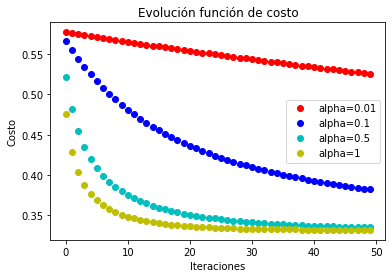

In [69]:
plt.plot(iteraciones_1,J_1,"ro", label="alpha=0.01")
plt.plot(iteraciones_2,J_2,"bo",label="alpha=0.1")
plt.plot(iteraciones_3,J_3,"co",label="alpha=0.5")
plt.plot(iteraciones_4,J_4,"yo",label="alpha=1")
plt.title("Evolución función de costo")
plt.legend(loc='center right')
plt.ylabel("Costo")
plt.xlabel("Iteraciones")
plt.show()

Podemos ver que con  𝛼=1  la función de costo pudo converger rápidamente a un valor estable y cercano al mínimo. Con 50 iteraciones y con  𝛼=1 , la función de costo vale 0.4174683. Ahora veamos que sucede con valores de $\alpha$ más grandes: 

In [86]:
J_5,iteraciones_5,theta_5 = Gradient_Descent(theta_inicial,X,Y,2,20)
J_6,iteraciones_6,theta_6 = Gradient_Descent(theta_inicial,X,Y,7,20)
J_7,iteraciones_7,theta_7 = Gradient_Descent(theta_inicial,X,Y,10,20)
J_8,iteraciones_8,theta_8 = Gradient_Descent(theta_inicial,X,Y,15,20)

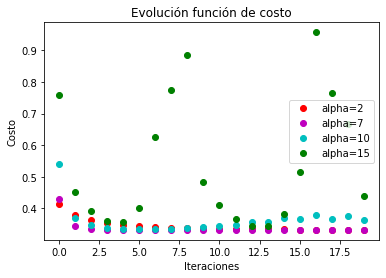

In [87]:
plt.plot(iteraciones_5,J_5,"ro", label="alpha=2")
plt.plot(iteraciones_6,J_6,"mo",label="alpha=7")
plt.plot(iteraciones_7,J_7,"co",label="alpha=10")
plt.plot(iteraciones_8,J_8,"go",label="alpha=15")
plt.legend(loc='center right')
plt.title("Evolución función de costo")
plt.ylabel("Costo")
plt.xlabel("Iteraciones")
plt.show()

Para resolver este notebook me quedaré con $\alpha = 7$ y con 20 iteraciones, ya que con estas variables la función de costo presenta un comportamiento estable y un valor muy pequeño. Con 20 iteraciones y con $\alpha=7$, el menor valor de la función de costo es 0.33182636 y el theta correspondiente se muestra a continuación:

In [89]:
theta_6

array([-0.70271391, -1.39225399,  1.73190075])

In [75]:
def listas_de_predicciones_sigmoid(SET,theta):

    lista_predicciones_azul = []
    lista_predicciones_rojo = []
    
    X = []
    for i in range(len(SET)):  
        X.append([1,SET[i][1],SET[i][2]])
    
    Xtheta = np.dot(X,theta)
    
    prediccion = Sigmoid(Xtheta)
    
    for pto in range(len(SET)):
    
        if (prediccion[pto] <= 0.5):
            lista_predicciones_azul.append([SET[pto][1], SET[pto][2]])
        if (prediccion[pto] > 0.5):
            lista_predicciones_rojo.append([SET[pto][1], SET[pto][2]])
        
    return np.array(lista_predicciones_azul), np.array(lista_predicciones_rojo)

### Visualización

In [90]:
prediccion_azul_train_sigmoid, prediccion_rojo_train_sigmoid = listas_de_predicciones_sigmoid(SET_train,theta_6)

prediccion_azul_train_sigmoid_t = prediccion_azul_train_sigmoid.transpose()
prediccion_rojo_train_sigmoid_t = prediccion_rojo_train_sigmoid.transpose()

In [91]:
prediccion_azul_test_sigmoid, prediccion_rojo_test_sigmoid = listas_de_predicciones_sigmoid(SET_test,theta_6)

prediccion_azul_test_sigmoid_t = prediccion_azul_test_sigmoid.transpose()
prediccion_rojo_test_sigmoid_t = prediccion_rojo_test_sigmoid.transpose()

Con esto podemos comparar visualmente las predicciones sobre el conjunto de entrenamiento y el conjunto de testeo, utilizando un modelo predictivo con la función sigmoid. A continuación se observan los 200 puntos simulados inicialmente que pertenecen al conjunto de entrenamiento.

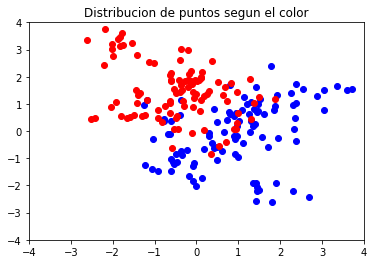

In [92]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

A continuación se observa la predicción hecha por la función sigmoid en el conjunto de entrenamiento:

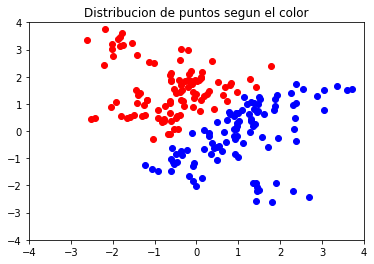

In [93]:
visualize_colors(prediccion_azul_train_sigmoid_t, prediccion_rojo_train_sigmoid_t)

A continuación observamos los 10000 puntos creados anteriormente que pertenecen al SET_test:

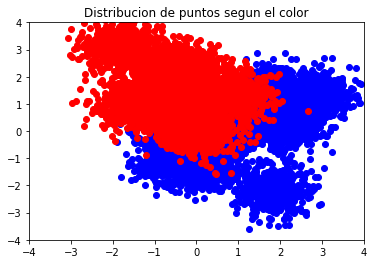

In [94]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

A continuación se observa la predicción hecha por la función sigmoid para estos puntos pertenecientes a SET_test:

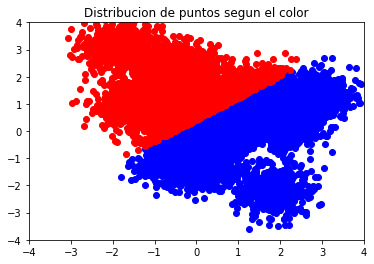

In [95]:
visualize_colors(prediccion_azul_test_sigmoid_t, prediccion_rojo_test_sigmoid_t)

### Evaluación de la hipotesis sigmoid en terminos de las metricas "Accuracy" y el "Test Error"

Recordemos que:

$$Accuracy = \frac{PC}{PC+ PI}$$ 
Con PC los puntos predichos correctamente y PI los puntos predichos incorrectamente

$$Test_{error} = 1 - accuracy$$

Con estas métricas evaluaremos la performance de la hipótesis de la función sigmoid. Evaluaremos estas dos métricas en ambos conjuntos de datos (el de entrenamiento y el de testeo).

In [96]:
def accuracy_funcion_sigmoid(SET, theta):

    ptos_correctos = 0
    ptos_incorrectos = 0
    
    X = []
    for i in range(len(SET)):  
        X.append([1,SET[i][1],SET[i][2]])
    
    Xtheta = np.dot(X,theta)
    
    prediccion = Sigmoid(Xtheta)
    
    for pto in range(len(SET)):
        
        if (((prediccion[pto] <= 0.5) and (SET[pto][3]==0)) or
            ((prediccion[pto] > 0.5) and (SET[pto][3]==1))):
            
            ptos_correctos = ptos_correctos + 1
        else:
            ptos_incorrectos = ptos_incorrectos + 1
            
    ratio = ptos_correctos/(ptos_correctos + ptos_incorrectos)
        
        
    print("puntos correctos: %d y puntos incorrectos: %d"%(ptos_correctos, ptos_incorrectos))
        
    return ratio

### Evaluación del modelo usando el conjunto de entrenamiento

In [97]:
train_accuracy_sigmoid = accuracy_funcion_sigmoid(SET_train, theta_6)
train_error_sigmoid = 1 - train_accuracy_sigmoid
print("train accuracy sigmoid: %.2f and test error sigmoid: %.2f "%(train_accuracy_sigmoid, train_error_sigmoid))

puntos correctos: 172 y puntos incorrectos: 28
train accuracy sigmoid: 0.86 and test error sigmoid: 0.14 


### Evaluación del modelo usando el conjunto de testeo

In [98]:
test_accuracy_sigmoid = accuracy_funcion_sigmoid(SET_test, theta_6)
test_error_sigmoid = 1 - test_accuracy_sigmoid
print("test accuracy sigmoid: %.2f and test error sigmoid: %.2f "%(test_accuracy_sigmoid, test_error_sigmoid))

puntos correctos: 8596 y puntos incorrectos: 1404
test accuracy sigmoid: 0.86 and test error sigmoid: 0.14 


Comparando el valor del Test error obtenido para las dos hipótesis analizadas, estos son bastante similares (prácticamente iguales). Esto muestra la consistencia del método gradient descent para encontrar los parámetros libres de J($\theta$), ya que obtuvo el mismo error que se calculó anteriormente de manera analítica para la hipótesis lineal. 